<a href="https://colab.research.google.com/github/nicolasmetallo/serverless-cnn-pytorch/blob/master/train_deploy_pytorch_serverless.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train CNN with PyTorch + Fastai and deploy on AWS Lambda
---

## Import libraries

In [0]:
import os
import io
import PIL
import sys
import tarfile
import time
import shutil
from datetime import datetime

# quick fix if you installed torch on a Mac: https://github.com/pytorch/pytorch/issues/20030
from fastai.vision import *
from fastai.callbacks import *
from fastai.widgets import *

## Create Dataset

### Download Images from Google for Class "A"

In [0]:
%%shell
pip install google_images_download

     |████████████████████████████████| 911kB 12.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
from google_images_download import google_images_download   # import library

response = google_images_download.googleimagesdownload()   # init the class
arguments = {
    "keywords":"Macri, Mauricio Macri, Presidente Macri",
    "limit":100,
    "print_urls":False}   # don't print any URL
paths = response.download(arguments)   # pass args


Item no.: 1 --> Item name = Macri
Evaluating...
Starting Download...
Completed Image ====> 1.220px-Presidente_Macri_en_el_Sillon_de_Rivadavia_%28cropped%29.jpg
Invalid or missing image format. Skipping...
Completed Image ====> 2.macri_1_crop1551468266549_crop1553221662421_crop1553556581334.jpg
Completed Image ====> 3.0036152039.jpg
Completed Image ====> 4.macri.jpg
Completed Image ====> 5.macri_joe_profile.jpg
Completed Image ====> 6.880x495_427907.jpg
Completed Image ====> 7.mauricio-macri-2017-gettyimages-631903252.jpg
Completed Image ====> 8.macri2_crop1550860057016.jpg
Completed Image ====> 9.time-100-mauricio-macri.jpg
Completed Image ====> 10.107cecc4e541bf7391680e7351cd942c20af8a9b_1.jpg
Completed Image ====> 11.macri-announces-that-argentina-is-committed-to-international-security-by-broadening-defence-cooperation-with-india.jpg
Completed Image ====> 12.Mochkofsky-Whats-Next-Mauricio-Macri.jpg
Completed Image ====> 13.k46FokV_8_930x525__1.jpg
Completed Image ====> 14.mauricio-m

### Find similar images and remove duplicates (Optional)
----
Source: https://docs.fast.ai/widgets.image_cleaner.html

Google Colab does not accept external widgets to run on these notebooks, that's why `ImageCleaner` won't work. You can still find similar images (`ds` and `idxs`) but you will need to remove the duplicates manually. I won't do that here because I don't care much about accuracy, so it's commented.

In [0]:
# # Build a databunch from the images you downloaded
# src = (ImageList.from_folder(Path('/content/downloads'))
#        .split_by_rand_pct()
#        .label_from_folder()
#        .transform(get_transforms(), size=224))

# db  = src.databunch(bs=16, num_workers=0)

# learn = cnn_learner(db, models.resnet34, metrics=[accuracy])
# learn.fit_one_cycle(3)

# ds, idxs = DatasetFormatter().from_similars(learn, layer_ls=[0,7,1], pool=None) # read the fastai docs to understand why these numbers

# # ds[idxs[0]][0] # show image

### Download images from the Open Image Dataset for Class "B"
---
Source: 
- https://storage.googleapis.com/openimages/web/index.html
- https://github.com/EscVM/OIDv4_ToolKit

In [0]:
%%shell
git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 399, done.
remote: Total 399 (delta 0), reused 0 (delta 0), pack-reused 399
Receiving objects: 100% (399/399), 34.05 MiB | 20.42 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [0]:
%%shell
cd OIDv4_ToolKit
pip install -r requirements.txt

     |████████████████████████████████| 1.6MB 9.7MB/s 
     |████████████████████████████████| 5.5MB 57.2MB/s 
     |████████████████████████████████| 51kB 28.2MB/s 
  Found existing installation: botocore 1.12.157
    Uninstalling botocore-1.12.157:
      Successfully uninstalled botocore-1.12.157
  Found existing installation: rsa 4.0
    Uninstalling rsa-4.0:
      Successfully uninstalled rsa-4.0


In [0]:
%%shell
cd OIDv4_ToolKit
python main.py downloader_ill --sub m --classes Person --type_csv validation --limit 300


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	


     _____                      _                 _             _____ _      _      
    |  __ \                    | |               | |           |_   _| |    | |     
    | |  | | _____      ___ __ | | ___   __ _  __| | ___ _ __    | | | |    | |     
    | |  | |/ _ \ \ /\ / / '_ \| |/ _ \ / _` |/ _` |/ _ \ '__|   | | | |    | |     
    | |__| | (_) \ V  V /| | | | | (_) | (_| | (_| |  __/ |     _| |_| |____| |____ 
    |_____/ \___/ \_/\_/ |_| |_|_|\___/ \__,_|\__,_|\___|_|    |_____|______|______|
                                            
            
        
   [ERROR] | Missing the class-descriptions.csv file.
[DOWNLOAD] | Do you want to download the missing file? [Y/n] Y
...101%, 0 MB, 84980

### Combine images into single folder

In [0]:
path = Path('/content/data')
path.mkdir(exist_ok=True, parents=True)

# move images for class "A" from google_images_download
(path/'macri').mkdir(exist_ok=True, parents=True)
images = [x for k,v in paths[0].items() for x in v if len(x)>0]
for image in images:
  file = Path(image)
  shutil.copy(image, 
              path/'macri'/file.name)
print(f'{len(images)} images were copied for class A')

# move images for class "B" from OID
(path/'not_macri').mkdir(exist_ok=True, parents=True)
images = [x for x in Path('/content/OIDv4_ToolKit/OID/Dataset_nl/validation/Person').glob('*.jpg')]
for image in images:
  shutil.copy(image, 
              path/'not_macri'/image.name)
print(f'{len(images)} images were copied for class B')

259 images were copied for class A
300 images were copied for class B


## Train your model

In [0]:
%%shell
pip install pretrainedmodels

### Helper functions

In [0]:
def arch_summary(arch):
  model = arch(False)
  tot = 0
  for i, l in enumerate(model.children()):
      n_layers = len(flatten_model(l))
      tot += n_layers
      print(f"({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})")


def get_groups(model, layer_groups):
  group_indices = [len(g) for g in layer_groups]
  curr_i = 0
  group = []
  for layer in model:
      group_indices[curr_i] -= len(flatten_model(layer))
      group.append(layer.__class__.__name__)
      if group_indices[curr_i] == 0:
          curr_i += 1
          print(f'Group {curr_i}:', group)
          group = []

def se_resnext50_32x4d(pretrained=False):
  pretrained = "imagenet" if pretrained else None
  model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
  return model
  
def get_data(path, size=224, bs=16, workers=None):
  tfms = get_transforms()
  n_gpus = num_distrib() or 1
  if workers is None: workers = min(8, num_cpus()//n_gpus)

  return (ImageList.from_folder(path).split_by_rand_pct()
          .label_from_folder().transform(tfms, size=size)
          .databunch(bs=bs, num_workers=workers)
          .presize(size, scale=(0.35,1))
          .normalize(imagenet_stats))

### Start training

(0) Sequential  : 4   layers (total: 4)
(1) Sequential  : 38  layers (total: 42)
(2) Sequential  : 50  layers (total: 92)
(3) Sequential  : 74  layers (total: 166)
(4) Sequential  : 38  layers (total: 204)
(5) AvgPool2d   : 1   layers (total: 205)
(6) Linear      : 1   layers (total: 206)
Group 1: ['Sequential', 'Sequential', 'Sequential', 'Sequential', 'Sequential']
Group 2: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


epoch,train_loss,valid_loss,accuracy,time
0,0.470243,0.269027,0.909091,00:13
1,0.347056,0.142055,0.954545,00:13
2,0.256294,0.173762,0.927273,00:13
3,0.258621,0.199829,0.927273,00:13
4,0.251065,0.156670,0.936364,00:13
5,0.218240,0.100791,0.963636,00:13
6,0.172852,0.229767,0.945455,00:13
7,0.160615,0.162914,0.954545,00:13
8,0.188099,0.186231,0.918182,00:13
9,0.193744,0.077685,0.972727,00:13


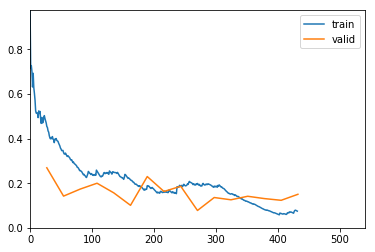

Better model found at epoch 0 with accuracy value: 0.9090909361839294.
Better model found at epoch 1 with accuracy value: 0.9545454382896423.
Better model found at epoch 5 with accuracy value: 0.9636363387107849.
Better model found at epoch 9 with accuracy value: 0.9727272987365723.
Epoch 14: reducing lr to 0.0005661305997198331
Epoch 15: early stopping


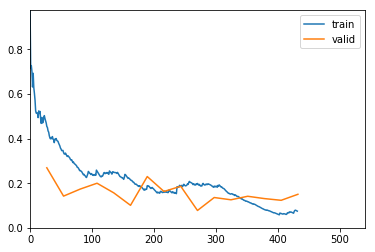

In [0]:
import pretrainedmodels

output = Path('/content/output')
output.mkdir(exist_ok=True, parents=True)
epochs=20
lr=1e-2

# create databunch
data = get_data(path)

# create cnn learner
arch = se_resnext50_32x4d
learn = cnn_learner(data, arch, metrics=[accuracy], 
                    callback_fns=[ShowGraph,])

# set callbacks
early_stopping = EarlyStoppingCallback(
    learn, monitor='accuracy', min_delta=1e-3, patience=5)
reduce_LR = ReduceLROnPlateauCallback(
    learn, monitor='accuracy', min_delta=1e-3, patience=4)
save_model = SaveModelCallback(
    learn,
    every="improvement",
    monitor='accuracy',
    name=output/'model_best')

# print cnn info
arch_summary(arch)
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

# train model
learn.fit_one_cycle(20, lr, div_factor=10, pct_start=0.3, callbacks=[early_stopping, reduce_LR, save_model])

### Export as model.tar.gz

In [0]:
# export model to pkl
learn = learn.load(output/'model_best')
learn.export(output/'model.pkl')

# convert to torch.jit and export to .tar.gz
save_texts(output/'classes.txt', data.classes)
trace_input = torch.ones(1, 3, 224, 224).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file = 'model_jit.pth'
torch.jit.save(jit_model, str(output/model_file))
tar_file = 'model.tar.gz'

with tarfile.open(output/tar_file, "w:gz") as f:
    f.add(output/model_file, arcname=model_file)
    f.add(output/'classes.txt', arcname='classes.txt')

print(f'{tar_file} was saved succesfully.')

model.tar.gz was saved succesfully.
